In [1]:
from glob import glob
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../../tools")
from plot_tools import plot_uv_map,plot_map_zoom
import xarray as xr
import matplotlib.pyplot as plt
import pickle
import gzip
import numpy
import netCDF4
import datetime
import os
from typing import Optional, Tuple

from scipy import stats


In [ ]:
year = 2010

filenames_drifters = sorted(glob(f'/Odyssey/private/t22picar/data/drifters/aoml/drifter_*_{year}.nc'))
ds_drifter = xr.open_mfdataset(filenames_drifters, combine='nested', concat_dim='date')
year_ds_drifter = ds_drifter.sel(date=ds_drifter["date.year"] == year)
year_ds_drifter = year_ds_drifter.compute()
year_ds_drifter_filtred = year_ds_drifter.where(year_ds_drifter['ums'] < 1000, drop=True)



In [25]:
lon_bins = np.linspace(-180.125, 179.916672 + 0.125, 1441)
lat_bins = np.linspace(-80.125, 90.125, 680)

lon = (lon_bins[1:] + lon_bins[:-1]) / 2
lat = (lat_bins[1:] + lat_bins[:-1]) / 2


In [62]:
# Make daily bin map with u, v mean
day_ds_drifter = year_ds_drifter_filtred.sel(date = "2010-02-22")

In [67]:
day_ds_drifter.ums.values.shape[0]

0

In [76]:
test = np.empty((lon.shape[0],lat.shape[0]))
test[:] = np.nan

In [77]:
test

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [68]:
# Make daily bin map with u, v mean
day_ds_drifter = year_ds_drifter_filtred.sel(date = "2010-01-10")
statistic,x_edge,y_edge,binnumber = stats.binned_statistic_2d(day_ds_drifter.lon.values, day_ds_drifter.lat.values, day_ds_drifter.ums.values, 'mean', bins=[lon_bins, lat_bins])

In [70]:
statistic.shape

(1440, 679)

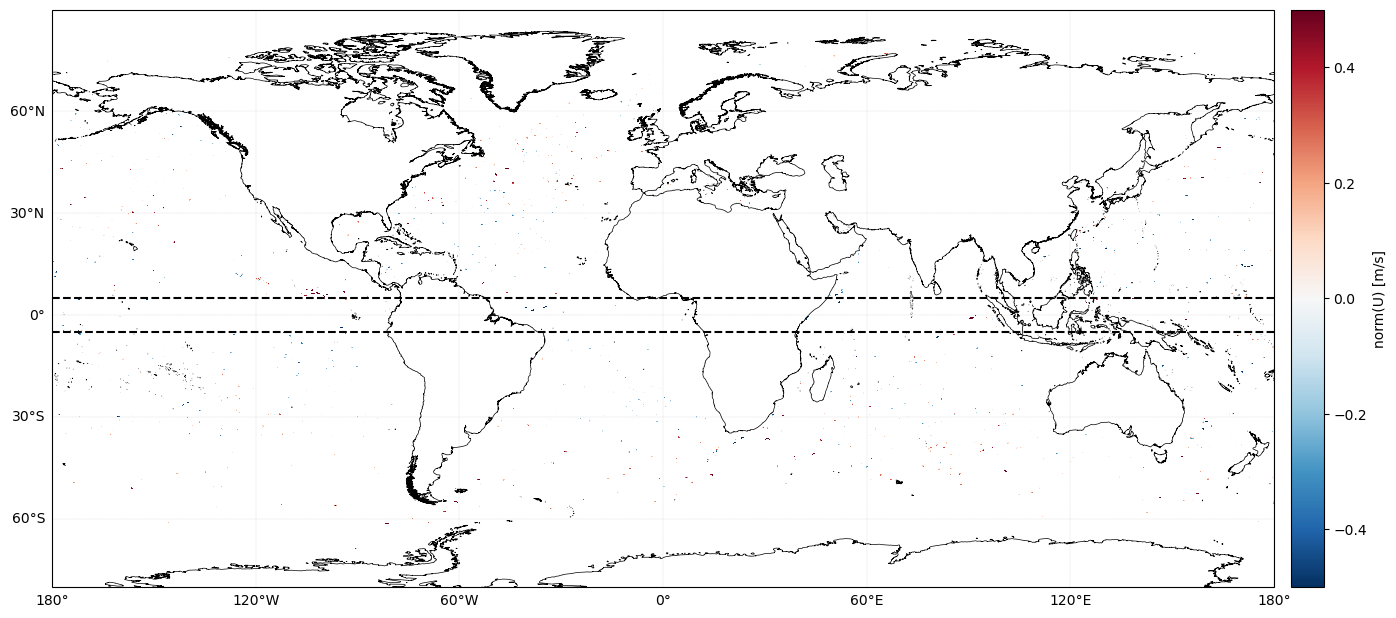

In [28]:
plot_uv_map(statistic.T,lon,lat,vmin=-0.5,vmax=0.5)

<xarray.Dataset> Size: 51GB
Dimensions:  (time: 3287, lat: 680, lon: 1440)
Coordinates:
    depth    float32 4B ...
  * time     (time) datetime64[ns] 26kB 2010-01-01 2010-01-02 ... 2018-12-31
  * lat      (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.7 -179.5 ... 179.4 179.7 179.9
Data variables:
    uo       (time, lat, lon) float64 26GB ...
    vo       (time, lat, lon) float64 26GB ...
Attributes:
    institution:               MERCATOR OCEAN
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    comment:                   CMEMS product
    title:                     daily mean fields from Global Ocean Physics An...
    copernicusmarine_version:  2.0.1

In [ ]:
from datetime import datetime, timedelta

lon_bins = np.linspace(-180.125, 179.916672 + 0.125, 1441)
lat_bins = np.linspace(-80.125, 90.125, 680)

lon = (lon_bins[1:] + lon_bins[:-1]) / 2
lat = (lat_bins[1:] + lat_bins[:-1]) / 2

start_date = datetime(2010, 1, 1)
#end_date = datetime(2019, 1, 1)
end_date = datetime(2010, 1, 3)

current_date = start_date
time_index = 0
year = 0

u_drifter_list =[]
v_drifter_list =[]

In [3]:
while current_date < end_date:
        
        check_year = current_date.year
        if check_year != year:
                print(check_year)
                year = check_year
                filenames_drifters = sorted(glob(f'/Odyssey/private/t22picar/data/drifters/cmems/drifter_*_{year}.nc'))
                ds_drifter = xr.open_mfdataset(filenames_drifters, combine='nested', concat_dim='date')
                ds_drifter = ds_drifter.sel(date=ds_drifter["date.year"] == year)
                ds_drifter = ds_drifter.compute()
                ds_drifter = ds_drifter.where(ds_drifter['ums'] < 1000, drop=True)
                ds_drifter = ds_drifter.where(ds_drifter['vms'] < 1000, drop=True) 

        # Make daily bin map with u, v mean
        day_ds_drifter = ds_drifter.sel(date = current_date)
        u_drifter,x_edge,y_edge,binnumber = stats.binned_statistic_2d(day_ds_drifter.lon.values, day_ds_drifter.lat.values, day_ds_drifter.ums.values, 'mean', bins=[lon_bins, lat_bins])
        v_drifter,x_edge,y_edge,binnumber = stats.binned_statistic_2d(day_ds_drifter.lon.values, day_ds_drifter.lat.values, day_ds_drifter.vms.values, 'mean', bins=[lon_bins, lat_bins])

        # Créer un DataArray pour "u"
        u_drifter_xr = xr.DataArray(
        u_drifter.T,
        dims=("lat", "lon"),
        coords={

                "lat": lat,
                "lon": lon,
        },
        name="u_drifter"
        ).expand_dims(time=[current_date])

        # Créer un DataArray pour "u"
        v_drifter_xr = xr.DataArray(
        v_drifter.T,
        dims=("lat", "lon"),
        coords={

                "lat": lat,
                "lon": lon,
        },
        name="v_drifter"
        ).expand_dims(time=[current_date])

        u_drifter_list.append(u_drifter_xr)
        v_drifter_list.append(v_drifter_xr)

        current_date += timedelta(days=1)  # Ajoute 1 an (approximation)
        time_index += 1

2010


In [7]:
# Concaténer tous les DataArrays le long de la dimension "time"
u_drifter = xr.concat(u_drifter_list, dim="time")
v_drifter = xr.concat(v_drifter_list, dim="time")

In [8]:

# Créer le Dataset final
ds = xr.Dataset({"u_drifter": u_drifter, "v_drifter": v_drifter})

print("Saving...")
save_file=f"/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_15m_4th.nc"

# Sauvegarder le DataArray en fichier NetCDF
ds.to_netcdf(save_file)

Saving...


In [78]:
save_file=f"/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_15m_4th.nc"

res_data = xr.open_dataset(save_file)
res_data

<xarray.Dataset> Size: 51GB
Dimensions:    (time: 3287, lat: 679, lon: 1440)
Coordinates:
  * time       (time) datetime64[ns] 26kB 2010-01-01 2010-01-02 ... 2018-12-31
  * lat        (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon        (lon) float64 12kB -180.0 -179.7 -179.5 ... 179.4 179.7 179.9
Data variables:
    u_drifter  (time, lat, lon) float64 26GB ...
    v_drifter  (time, lat, lon) float64 26GB ...

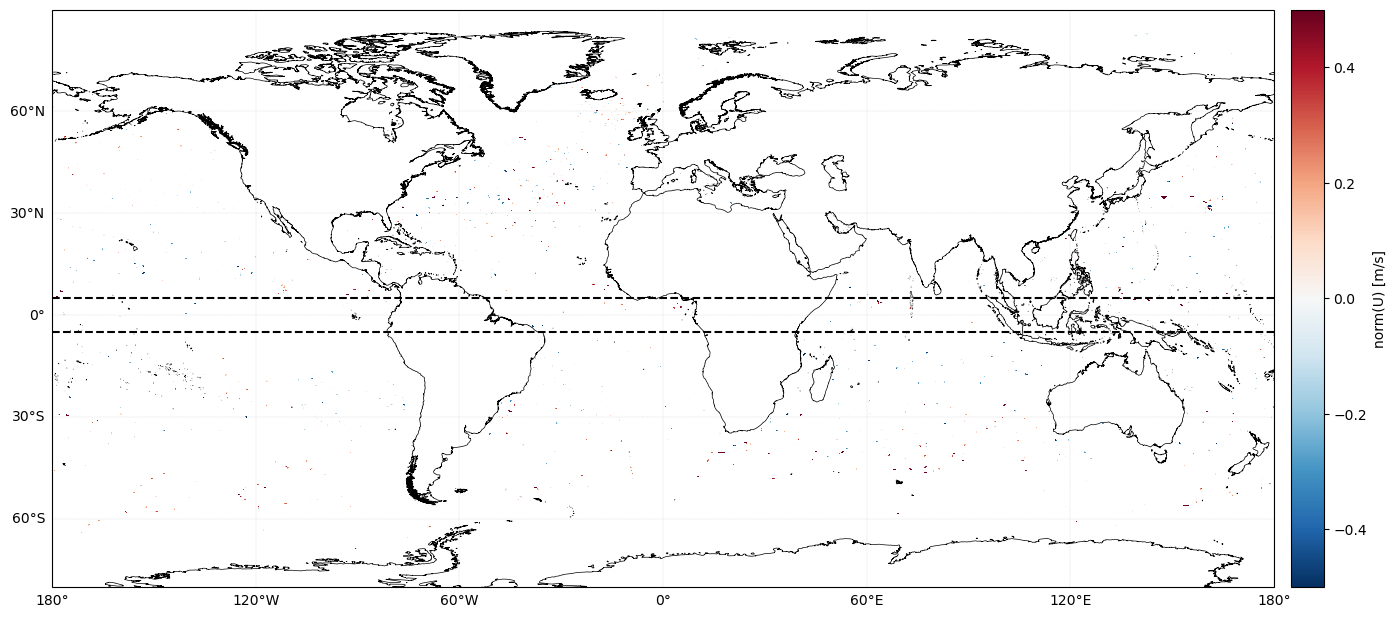

In [82]:
plot_uv_map(res_data.u_drifter[-100],res_data.lon,res_data.lat,vmin=-0.5,vmax=0.5)